In [70]:
import sys
import random
import os
import numpy as np
import iisignature as iis
import matplotlib.pyplot as plt
import gudhi
from gudhi import plot_persistence_diagram
from gudhi import plot_persistence_density
from gtda.homology import VietorisRipsPersistence
from gtda.homology import FlagserPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.diagrams import Amplitude
from gudhi.representations.vector_methods import Entropy
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram
import numpy.random as rd
import gudhi.representations
import random
from scipy.stats import zscore
%run FUNCTIONS.ipynb

In [71]:
def logistic(r, x):
    return (1 - r * (x**2))
    # alternative  chaotic map
    # return(4*x*(1-x))


# See book of Kaneko for parameters of eps and/or r to have different regimes
# or https://en.wikipedia.org/wiki/Coupled_map_lattice for notable regimes


# Generate couple map lattice according to this equation: x_i^t= (1-\eps)f[x_i^{t-1}] + \eps/order \sum_{j in \neighbours} f[x_j]^{t-1}
def generate_couple_map(T, N, epsilon, transient_time, r, order=2):
    series = {}

    # Filing the dictionary with N initial random values
    for index_series in range(0, N):
        s = random.random()
        series[index_series] = [s]

    # Generate the coupled maps for a length of size T (yet, we discard the first transient_time elements to remove the transient)
    for i in range(1, T + transient_time + 1):
        for index_series in range(0, N):
            order_k_term = compute_neighbours(N, series, epsilon, index_series, i - 1, r, order)
            new_point = (1 - epsilon) * logistic(r,series[index_series][i - 1]) + order_k_term
            series[index_series].append(new_point)
    return(series)



def compute_neighbours(N, series, epsilon, index_series, i, r, order=2):
    eps_overN = epsilon * (1 / order)
    term_left_right = int(order / 2)

    term = 0
    # Sum over the left neighbors with periodic boundary conditions
    for s in range(1, term_left_right + 1):
        term += logistic(r, series[(index_series - s) % N][i])

    # Sum over the right neighbors with periodic boundary conditions
    for s in range(1, term_left_right + 1):
        term += logistic(r, series[(index_series + s) % N][i])

    # if order is odd, then take the neighbors in an asymmetric way, int(order/2) on the left, int(order/2)+1 on the right
    if order % 2 == 1:
        s = term_left_right + 1
        term += logistic(r, series[(index_series + s) % N][i])

    return(term * eps_overN)

In [72]:
data_PS=generate_couple_map(20000,100,0.4, 1, 1.71, order=2)
ts_PS=np.zeros((401,100))
for j in range(100):
    ts_PS[:,j]=data_PS[j][10000::25]
    
    
data_CBMD=generate_couple_map(20000,100,0.1, 1, 1.85, order=2)
ts_CBMD=np.zeros((401,100))
for j in range(100):
    ts_CBMD[:,j]=data_CBMD[j][10000::25]
    
data_FDC=generate_couple_map(20000,100,0.3, 1, 2.00, order=2)
ts_FDC=np.zeros((401,100))
for j in range(100):
    ts_FDC[:,j]=data_FDC[j][10000::25]
    
data_STI=generate_couple_map(20000,100,0.6, 1, 1.75, order=2)
ts_STI=np.zeros((401,100))
for j in range(100):
    ts_STI[:,j]=data_STI[j][10000::25]
    
    
data_DT=generate_couple_map(20000,100,0.1, 1, 1.895, order=2)
ts_DT=np.zeros((401,100))
for j in range(100):
    ts_DT[:,j]=data_DT[j][10000::25]

In [22]:
# Setting parameters
indifference_value=0.05
length=120

In [23]:
# HYPER COHERENCE CURVES

# Hyper PS
hyp_PS=hyper_vector(ts_PS,indifference_value,length) 
    
    
# Hyper DT
hyp_DT=hyper_vector(ts_DT,indifference_value,length)    

    
# Hyper STI
hyp_STI=hyper_vector(ts_STI,indifference_value,length)
    
    
# Hyper FDC
hyp_FDC=hyper_vector(ts_FDC,indifference_value,length)
    
    
# Hyper CBMD
hyp_CBMD=hyper_vector(ts_CBMD,indifference_value,length)
    


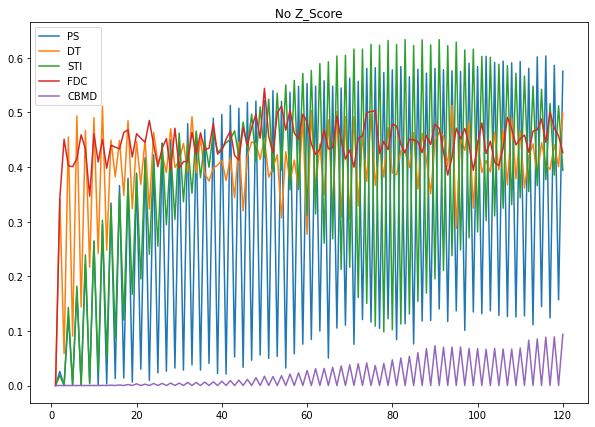

In [32]:

x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("No Z_Score")
plt.plot(x,hyp_PS)
plt.plot(x,hyp_DT)
plt.plot(x,hyp_STI)
plt.plot(x,hyp_FDC)
plt.plot(x,hyp_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("No_Z_Score.png")
plt.show()

In [25]:
# z scoring
# HYPER COHERENCE CURVES

# Hyper PS
ts_PS_z=zscore(ts_PS,axis=0)
hyp_PS_z=hyper_vector(ts_PS_z,indifference_value,length)
    
    
# Hyper DT
ts_DT_z=zscore(ts_DT,axis=0)
hyp_DT_z=hyper_vector(ts_DT_z,indifference_value,length)
    

# Hyper STI
ts_STI_z=zscore(ts_STI,axis=0)
hyp_STI_z=hyper_vector(ts_STI_z,indifference_value,length)
    
    
# Hyper FDC
ts_FDC_z=zscore(ts_FDC,axis=0)
hyp_FDC_z=hyper_vector(ts_FDC_z,indifference_value,length)
    
    
# Hyper CBMD
ts_CBMD_z=zscore(ts_CBMD,axis=0)
hyp_CBMD_z=hyper_vector(ts_CBMD_z,indifference_value,length)

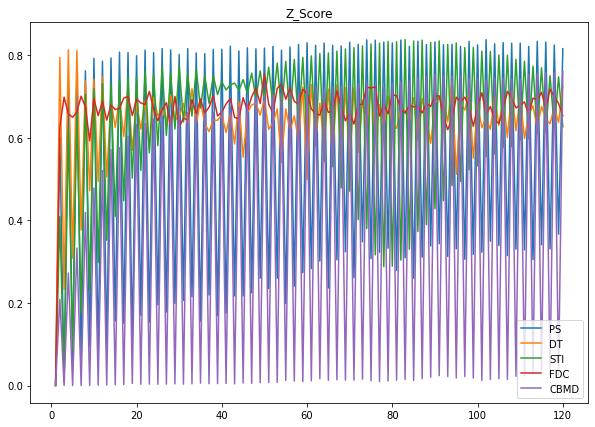

In [31]:
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Z_Score")
plt.plot(x,hyp_PS_z)
plt.plot(x,hyp_DT_z)
plt.plot(x,hyp_STI_z)
plt.plot(x,hyp_FDC_z)
plt.plot(x,hyp_CBMD_z)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Z_Score.png")
plt.show()

In [40]:
def en_1_vector(time_series,length):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    en_1_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        L=lead_matrix_1(sub_ts)
        dgm_clique=rev_undirected(L)
        PE = PersistenceEntropy()
        pe_feat = PE.fit_transform(dgm_clique)
        en_1_ts.append(pe_feat[0,1])
    return en_1_ts

In [73]:
length=150

In [74]:
# Entropy  curves, no zscore

# Hyper PS
en_PS=en_1_vector(ts_PS,length) 
 
    
# Hyper DT
en_DT=en_1_vector(ts_DT,length)    

    
# Hyper STI
en_STI=en_1_vector(ts_STI,length)
    
    
# Hyper FDC
en_FDC=en_1_vector(ts_FDC,length)
    
    
# Hyper CBMD
en_CBMD=en_1_vector(ts_CBMD,length)
    

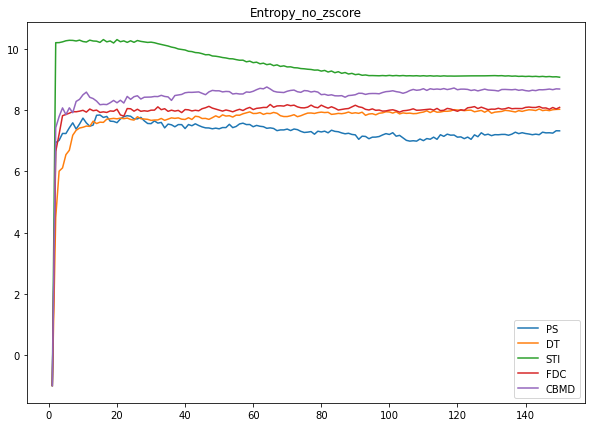

In [75]:
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Entropy_no_zscore")
plt.plot(x,en_PS)
plt.plot(x,en_DT)
plt.plot(x,en_STI)
plt.plot(x,en_FDC)
plt.plot(x,en_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_no_z_score.png")
plt.show()

In [76]:
# Hyper PS
ts_PS_z=zscore(ts_PS,axis=0)
en_PS=en_1_vector(ts_PS_z,length) 
 
    
# Hyper DT
ts_DT_z=zscore(ts_DT,axis=0)
en_DT=en_1_vector(ts_DT_z,length)    

    
# Hyper STI
ts_STI_z=zscore(ts_STI,axis=0)
en_STI=en_1_vector(ts_STI_z,length)
    
    
# Hyper FDC
ts_FDC_z=zscore(ts_FDC,axis=0)
en_FDC=en_1_vector(ts_FDC_z,length)
    
    
# Hyper CBMD
ts_CBMD_z=zscore(ts_CBMD,axis=0)
en_CBMD=en_1_vector(ts_CBMD_z,length)

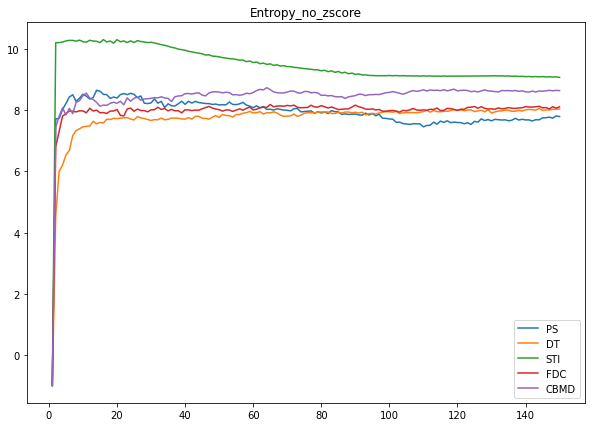

In [77]:
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Entropy_no_zscore")
plt.plot(x,en_PS)
plt.plot(x,en_DT)
plt.plot(x,en_STI)
plt.plot(x,en_FDC)
plt.plot(x,en_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Entropy_no_z_score.png")
plt.show()

In [78]:
def am_1_vector(time_series,length):
    l=time_series.shape[0]
    N=time_series.shape[1]
    h=np.modf(l/length)[1]
    am_1_ts=[]
    for i in range(1,length+1):
        sub_ts=time_series[:np.int64(h)*i,:]
        L=lead_matrix_1(sub_ts)
        dgm_clique=rev_undirected(L)
        A=Amplitude()
        ampl_feat=A.fit_transform(dgm_clique)
        am_1_ts.append(ampl_feat[0,1])
    return am_1_ts

In [79]:
length=200

In [80]:
# Entropy  curves, no zscore

# Hyper PS
am_PS=am_1_vector(ts_PS,length) 
 
    
# Hyper DT
am_DT=am_1_vector(ts_DT,length)    

    
# Hyper STI
am_STI=am_1_vector(ts_STI,length)
    
    
# Hyper FDC
am_FDC=am_1_vector(ts_FDC,length)
    
    
# Hyper CBMD
am_CBMD=am_1_vector(ts_CBMD,length)

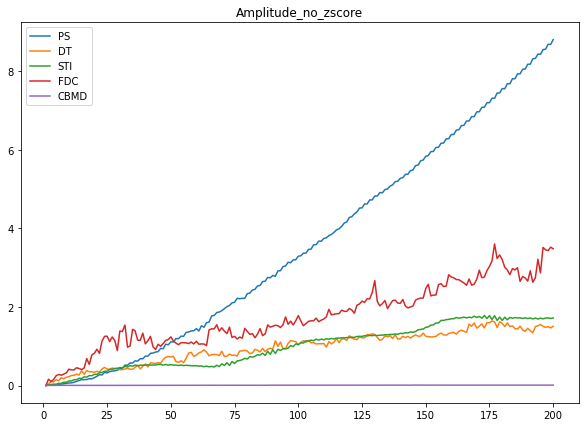

In [81]:
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Amplitude_no_zscore")
plt.plot(x,am_PS)
plt.plot(x,am_DT)
plt.plot(x,am_STI)
plt.plot(x,am_FDC)
plt.plot(x,am_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Amplitude_no_z_score.png")
plt.show()

In [82]:
# Hyper PS
ts_PS_z=zscore(ts_PS,axis=0)
am_PS=am_1_vector(ts_PS_z,length) 
 
    
# Hyper DT
ts_DT_z=zscore(ts_DT,axis=0)
am_DT=am_1_vector(ts_DT_z,length)    

    
# Hyper STI
ts_STI_z=zscore(ts_STI,axis=0)
am_STI=am_1_vector(ts_STI_z,length)
    
    
# Hyper FDC
ts_FDC_z=zscore(ts_FDC,axis=0)
am_FDC=am_1_vector(ts_FDC_z,length)
    
    
# Hyper CBMD
ts_CBMD_z=zscore(ts_CBMD,axis=0)
am_CBMD=am_1_vector(ts_CBMD_z,length)

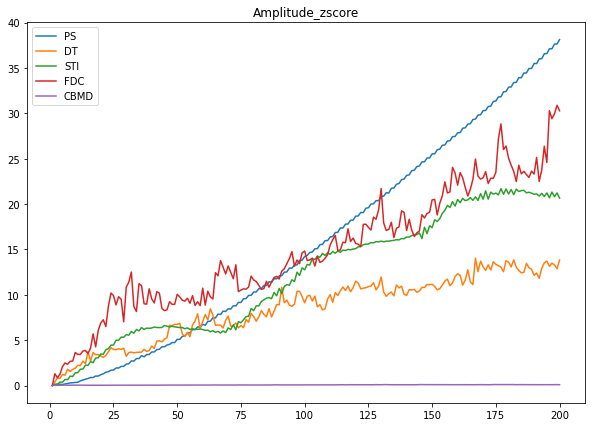

In [83]:
x=range(1,length+1)
plt.figure(figsize=(10,7))
plt.title("Amplitude_zscore")
plt.plot(x,am_PS)
plt.plot(x,am_DT)
plt.plot(x,am_STI)
plt.plot(x,am_FDC)
plt.plot(x,am_CBMD)
plt.legend(["PS","DT","STI","FDC","CBMD"])
plt.savefig("Amplitude_z_score.png")
plt.show()